In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import  load_files
from sklearn.datasets.base import Bunch
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
import statistics as st

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

C:\Programs\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
def preprocesor_call(content):
    return content.lower()[9:]

data: Bunch = load_files('../SEM/data/',encoding='utf-8',decode_error='replace')
vectorizer = TfidfVectorizer(
    preprocessor=preprocesor_call,
)
X = vectorizer.fit_transform(data.data)
y = data.target

###Reduce dimendion for visualization

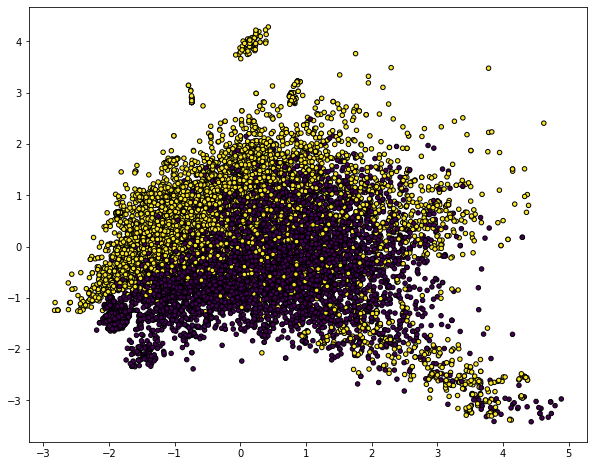

In [3]:
pca = make_pipeline(
    TruncatedSVD(n_components=500), 
    StandardScaler(),
    PCA(svd_solver='arpack',n_components=2)
)
Xviz = pca.fit_transform(X,y)
random_indices = np.random.choice(Xviz.shape[0], min(15000,Xviz.shape[0]), replace=False)
plt.figure(figsize=(10, 8))
plt.scatter(Xviz[random_indices, 0], Xviz[random_indices, 1], c=y[random_indices],s=20, edgecolor='k')
plt.show()

Its posible to see that data transfomed to tf-idf matrix (without any preprocessing),
 should be quite easily separable, even with some dimensionality reduction.

'SPAM'

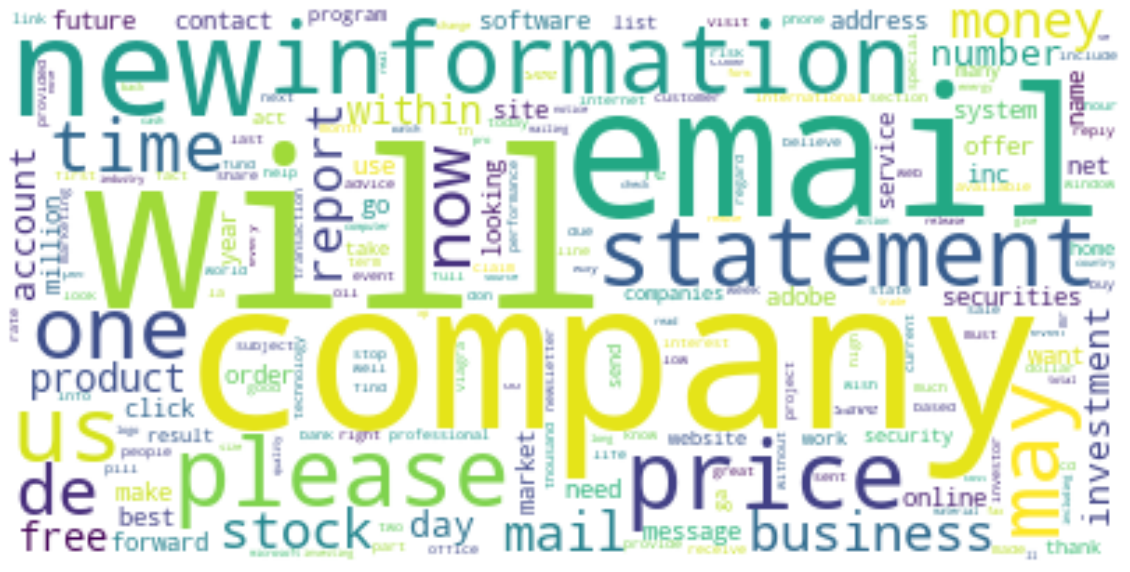

In [4]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

spam_indexes = np.argwhere(y == 1).flatten()
spam_list = [ data.data[index][9:] for index in spam_indexes]
spam_string = ' '.join(spam_list)
wordcloud_spam = WordCloud(
    background_color="white",
    collocations=False,
    collocation_threshold=5
).generate(spam_string)
display("SPAM")
f = plt.figure(figsize = (20,20))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

'Enron mail.'

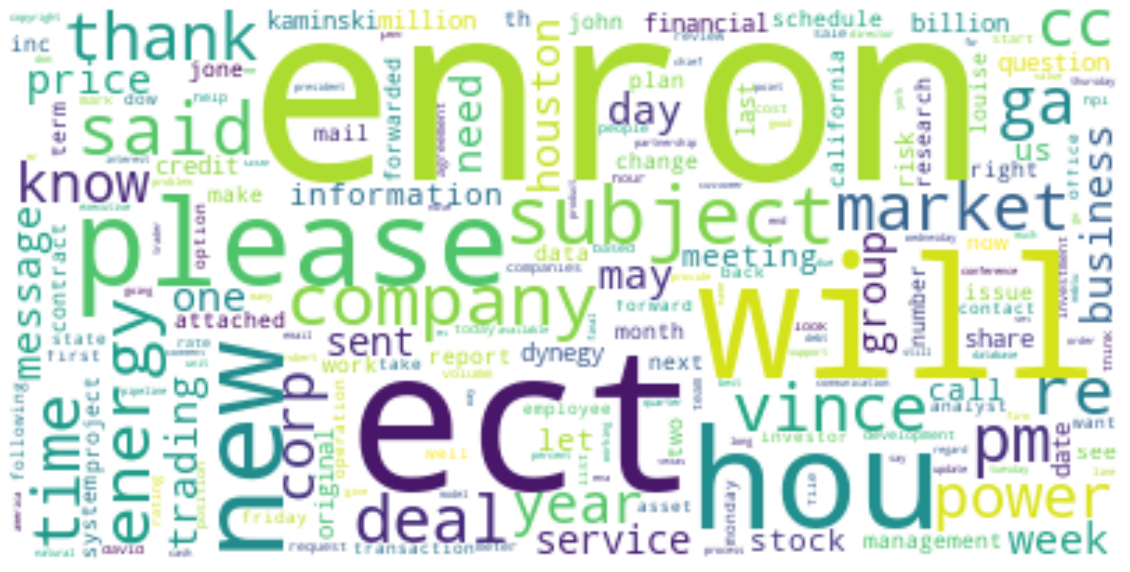

In [5]:
email_indexes = np.argwhere(y == 0).flatten()
email_list =  [ data.data[index][9:] for index in email_indexes]
spam_string = ' '.join(email_list)
wordcloud = WordCloud(
    background_color="white",
    collocations=False,
    collocation_threshold=5
).generate(spam_string)
plt.figure(figsize = (20,20))
display("Enron mail.")
plt.imshow( wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=random.randint(0,100))

## Classifier selection.

In [6]:
def evaluate(clf, cv=15, n_jobs=5):
    result = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1',n_jobs=n_jobs)
    display('mean f1: ' + str(st.mean(result)))
    display('variance: ' + str(st.variance(result)))
    display('stdev: ' + str(st.stdev(result)))

In [8]:
svc = LinearSVC()
evaluate(svc, cv=15)

'mean f1: 0.9892928972313499'

'variance: 1.3224907286662777e-05'

'stdev: 0.0036366065619836824'

In [9]:
svc2 = LinearSVC(penalty='l1',dual=False)
evaluate(svc2, cv=5)

'mean f1: 0.9814229604730899'

'variance: 1.363575172695137e-05'

'stdev: 0.003692661875524399'

In [10]:
svc3 = LinearSVC(class_weight='balanced')
evaluate(svc3, cv=5)

'mean f1: 0.9883648480663368'

'variance: 4.9031162065028846e-06'

'stdev: 0.002214298129544187'

In [11]:
from sklearn.linear_model._perceptron import Perceptron
peceptron= Perceptron()
evaluate(peceptron, cv=15)

'mean f1: 0.9878374514889586'

'variance: 2.1091280611696587e-05'

'stdev: 0.0045925244269025495'

In [12]:
from sklearn.linear_model._logistic import LogisticRegression
regression= LogisticRegression()
evaluate(regression, cv=15, n_jobs=5)

'mean f1: 0.9824242087804426'

'variance: 2.4661751130833526e-05'

'stdev: 0.004966059920181544'

#### This one seems to be the best choice

In [13]:
from sklearn.linear_model._passive_aggressive import PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(fit_intercept=True)
evaluate(pac, cv=15, n_jobs=5)

'mean f1: 0.9908369910665297'

'variance: 1.2889957437035945e-05'

'stdev: 0.0035902586866458446'

In [14]:
dtc = DecisionTreeClassifier()
evaluate(dtc, cv=15, n_jobs=7)

'mean f1: 0.949413254492899'

'variance: 5.990189211379231e-05'

'stdev: 0.007739631264717481'

In [15]:
rfc = RandomForestClassifier()
evaluate(rfc, cv=5, n_jobs=7)

'mean f1: 0.9829185669721392'

'variance: 6.306348577057656e-06'

'stdev: 0.002511244427979414'

In [16]:
voting = VotingClassifier(
    estimators=[
       ('LinearSVC', LinearSVC(class_weight='balanced')),
       ('DecisionTreeClassifier', DecisionTreeClassifier()),
       ('RandomForestClassifier', RandomForestClassifier()),
       ('LogisticRegression', LogisticRegression()),
       ('PassiveAggressiveClassifier' , PassiveAggressiveClassifier())
    ],
)
evaluate(voting, cv=5)

'mean f1: 0.987447023479633'

'variance: 9.208913631745607e-06'

'stdev: 0.0030346191905650383'

In [17]:
bagging = BaggingClassifier(
    base_estimator=LinearSVC(class_weight='balanced'),
    n_estimators=20, 
    max_samples=1.0,
    max_features=0.8,
    random_state=0
)
evaluate(voting, cv=5)

'mean f1: 0.9879071602447548'

'variance: 8.41200523446282e-06'

'stdev: 0.0029003457094737553'

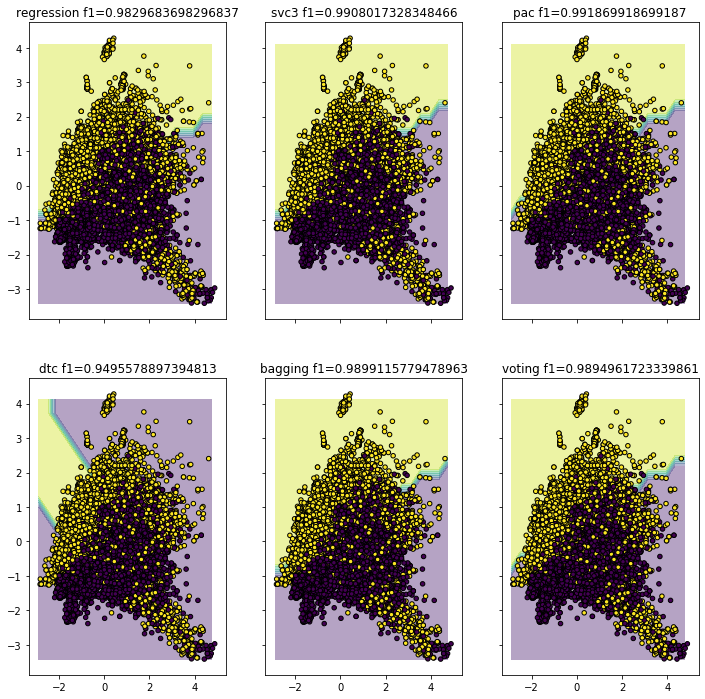

In [18]:
from itertools import product
# Plotting decision regions
step = 20

x_min, x_max = Xviz[:, 0].min(), Xviz[:, 0].max() + 0.2
y_min, y_max = Xviz[:, 1].min(), Xviz[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min)/step),
                     np.arange(y_min, y_max, (y_max - y_min)/step))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(12, 12))
XX = np.c_[xx.ravel(), yy.ravel()]
XX = pca.inverse_transform(XX)
for idx, clf, tt in zip(product([0,1], [0, 1, 2]),
                        [regression, svc3, pac, dtc,bagging, voting ],
                        ['regression', 'svc3', 'pac','dtc', 'bagging' , 'voting']):
    clf.fit(X_train, y_train)
    score = f1_score(clf.predict(X_test), y_test, average='micro')
    Z = clf.predict(XX)
    Z = Z.reshape((step,step))
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(Xviz[random_indices, 0], Xviz[random_indices, 1], c=y[random_indices],
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt + ' f1=' + str(score))

plt.show()

In [7]:
from sklearn.linear_model._passive_aggressive import PassiveAggressiveClassifier
display('AHOY6')
scoring = {'F1': make_scorer(f1_score, average='micro')}
max_samples = [1.0]
max_features = [0.7]
n_estimators = [500]
bootstrap=[True,False]
bootstrap_features=[True,False]
class_weight=['balanced', None]
param_grid = dict(
    bootstrap=bootstrap,
    bootstrap_features=bootstrap_features,
    max_samples=max_samples,
    max_features=max_features,
    n_estimators=n_estimators,
    base_estimator__max_iter=[1000]
)
bagging = BaggingClassifier(
    base_estimator=PassiveAggressiveClassifier(fit_intercept=True),
    random_state=np.random.RandomState()
)
gs = GridSearchCV(
    bagging, 
    param_grid, 
    scoring=scoring, 
    refit='F1',
    return_train_score=True,
    n_jobs=7,
    verbose=50,
    cv=3
)
gs.fit(X_train, y_train)
display(gs.best_params_)
hyper_bag = gs.best_estimator_
evaluate(hyper_bag, cv=5)

'AHOY6'

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=7)]: Done   2 out of  12 | elapsed:  3.0min remaining: 14.8min
[Parallel(n_jobs=7)]: Done   3 out of  12 | elapsed:  3.0min remaining:  9.1min
[Parallel(n_jobs=7)]: Done   4 out of  12 | elapsed:  3.1min remaining:  6.2min
[Parallel(n_jobs=7)]: Done   5 out of  12 | elapsed:  3.1min remaining:  4.4min
[Parallel(n_jobs=7)]: Done   6 out of  12 | elapsed:  3.1min remaining:  3.1min
[Parallel(n_jobs=7)]: Done   7 out of  12 | elapsed:  3.3min remaining:  2.3min
[Parallel(n_jobs=7)]: Done   8 out of  12 | elapsed:  5.4min remaining:  2.7min
[Parallel(n_jobs=7)]: Done   9 out of  12 | elapsed:  5.4min remaining:  1.8min
[Parallel(n_jobs=7)]: Done  10 out of  12 | elapsed:  5.4min remaining:  1.1min
[Parallel(n_jobs=7)]: Done  12 out of  12 | elapsed:  5.5min remaining:    0.0s
[Par

{'base_estimator__max_iter': 1000,
 'bootstrap': False,
 'bootstrap_features': False,
 'max_features': 0.7,
 'max_samples': 1.0,
 'n_estimators': 500}

'mean f1: 0.9916207379124606'

'variance: 1.4730088428942652e-06'

'stdev: 0.0012136757569030804'

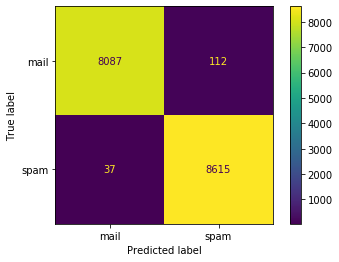

In [22]:
from sklearn.metrics import plot_confusion_matrix
display()
plot_confusion_matrix(hyper_bag, X_test, y_test, display_labels=['mail','spam'],values_format='d')

In [14]:
score = f1_score(hyper_bag.predict(X_test), y_test, average='micro')
display('final f1:' + str(score))

'final f1:0.9911577947896267'

## Conclusion in points

- PassiveAggresiveClassifier (a.k.a. PAC )is better than SVM for dataset with realy high number of features (+/- 0.01 point of F1 score)
- I focused solely on F1 score nut i think that way more important is to avoid any mail classified as spam, and as secondary metric minimize the other errors
So TPR would be maybe better but since we use only F1 whole semester i was strongly biased towards it
- maybe i did some mistakes somewhere but even the SVM with radial basis kernel was quite slower than PAC
- Bagging even thought tuned by exhaustive grid search does not improve model much (+/- 0.001 point of F1 score i i recall correctly)
- maybe i should experiment more with dimensionality reduction (but as i understand SVM and other kernel based classifiers should not mind the high dimensionality)
- The data was FLAWED. i used enron mail dataset (it was easiest to find) and it contains many misleading words see the wordclouds (ENRON, Billion)
which affects the classification at this moment i am not able to tell how the odel would perform on the regular mail
- i strived to achive f1=1.0 but after many reruns i was not able to find model and/or parameters to achive this
- One more idea is to experiment with different encoding for example [universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder/1)
 or [wapiti](https://wapiti.limsi.fr/manual.html)
- The reverse transformation from 2D space back to 1000+ space is slow inefficient but produces nice visualizations